In [2]:
from subprocess import call
import copy
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib notebook

In [3]:
PTS_P_FILE = "pts_p_file.csv"
PTS_Q_FILE = "pts_q_file.csv"
PERF_FILE = "perf_file.csv"
PROGRAM_PATH = "./main"

In [4]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 5
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

In [5]:
# Random point generation in square region
def generate_rand_pts_sq(x, y, r, num):
    ret_list = []
    for i in range(num):
        ret_list.append((2 * r * np.random.random_sample() + x - r,
                     2 * r * np.random.random_sample() + y - r))
    return ret_list

In [6]:
# Random point generation in disk region (discard method)
def generate_rand_pts_disk(x, y, r, num):
    ret_list = []
    i = 0
    while i < num:
        pnt = (
            (2 * r * np.random.random_sample() + x - r),
            (2 * r * np.random.random_sample() + y - r)
        )
        if (pnt[0] - x)**2 + (pnt[1] - y)**2 <= r**2:
            ret_list.append(pnt)
            i += 1
    return ret_list

In [7]:
# Random point generation in disk region (discard method)
def generate_rand_pts_circ(x, y, r, num):
    ret_list = []
    for i in range(num):
        theta = 2 * np.pi * np.random.random_sample()
        pnt = (
            r * np.cos(theta),
            r * np.sin(theta)
        )
        ret_list.append(pnt)
    return ret_list

In [8]:
def write_pts_list(pts_list, PTS_FILE):
    with open(PTS_FILE, "w") as pts_file:
        for pnt in pts_list:
            pts_file.write(str(pnt[0]) + "," + str(pnt[1]) + "\n")

In [9]:
def read_pts_list(PTS_FILE):
    pts_list = []
    with open(PTS_FILE) as pts_file:
        csv_reader = csv.reader(pts_file, delimiter=",")
        for row in csv_reader:
            pts_list.append(tuple(map(float, row)))
        return pts_list

In [10]:
def move_pnt(pnt, delta_x, delta_y):
    new_pnt = (pnt[0] + delta_x, pnt[1] + delta_y)
    return new_pnt

In [11]:
def replace_pnt(pts_list, pnt, new_pnt): # returns new list with pnt replaced with new_pnt
    assert pnt in pts_list
    ret_list = copy.deepcopy(pts_list)
    ret_list.remove(pnt)
    ret_list.append(new_pnt)
    return ret_list

In [12]:
def plot_pts_list(pts_list):
    plt.scatter(np.array(pts_list)[:,0], np.array(pts_list)[:,1], s=4, c=[[0,0,0]])
    plt.grid(True)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    plt.axes().set_aspect('equal')
    plt.show()

In [13]:
def run_average(num_iter, samp_func, xp, yp, rp, np, xq, yq, rq, nq):
    perf_dict = dict()
    for i in range(num_iter):
        write_pts_list(samp_func(xp, yp, rp, np), PTS_P_FILE)
        write_pts_list(samp_func(xq, yq, rq, nq), PTS_Q_FILE)
        call(PROGRAM_PATH)
        with open(PERF_FILE) as perf_file:
            csv_reader = csv.reader(perf_file, delimiter=",")
            for row in csv_reader:
                if (row[0] in perf_dict):
                    perf_dict[row[0]] += float(row[1])
                else:
                    perf_dict[row[0]] = float(row[1])
    for i in perf_dict.keys():
        perf_dict[i] /= num_iter
    return perf_dict

In [14]:
sq_res = [run_average(1000, generate_rand_pts_sq, *(-1000, 0, 500, 2**i), *(-1000, 0, 500, 2**i))['tang'] for i in range(16)]

In [15]:
circ_res = [run_average(1000, generate_rand_pts_circ, *(-1000, 0, 500, 2**i), *(-1000, 0, 500, 2**i))['tang'] for i in range(16)]

In [16]:
disk_res = [run_average(1000, generate_rand_pts_disk, *(-1000, 0, 500, 2**i), *(-1000, 0, 500, 2**i))['tang'] for i in range(16)]

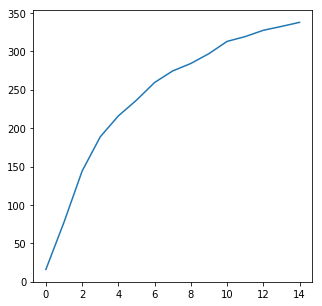

In [19]:
plt.plot(sq_res)

Text(0.5, 0, 'Polygon size (2^x)')

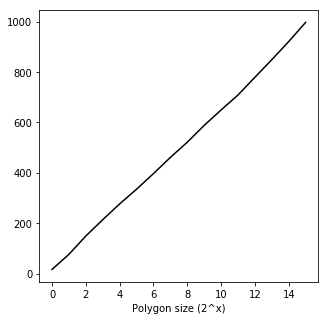

In [22]:
plt.plot(circ_res, c=(0,0,0))
plt.xlabel("Polygon size (2^x)")

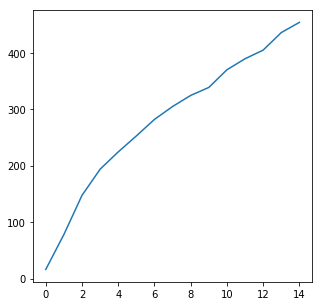

In [23]:
plt.plot(disk_res)

In [17]:
sq_res

[16.41,
 77.905,
 145.531,
 189.295,
 216.04,
 239.988,
 257.665,
 271.783,
 285.58,
 298.707,
 309.937,
 319.422,
 325.527,
 332.519,
 338.45,
 342.493]

In [18]:
circ_res

[16.316,
 76.176,
 148.889,
 213.624,
 276.383,
 334.66,
 396.601,
 460.833,
 521.057,
 587.915,
 649.054,
 708.362,
 778.851,
 848.617,
 920.486,
 996.625]

In [19]:
disk_res

[15.865,
 77.384,
 144.117,
 186.961,
 222.182,
 251.854,
 276.92,
 302.073,
 323.723,
 340.27,
 366.577,
 393.628,
 404.821,
 436.493,
 453.361,
 465.007]